# 📌 필수 라이브러리 불러오기

In [1]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 처리
import pandas as pd
import numpy as np

# 데이터 전처리
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold

# 불균형 데이터 처리
from imblearn.over_sampling import SMOTE

# 모델 평가
from sklearn.metrics import roc_auc_score

# 딥러닝 모델 (TensorFlow)
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

In [2]:
# TensorFlow GPU 가속 확인
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU 가속 활성화됨!")
else:
    print("⚠️ GPU를 감지할 수 없습니다. CPU에서 실행됩니다.")

✅ GPU 가속 활성화됨!


# ------------------------------------------------------------------------------------
# 📌 1. 데이터 로드 및 UID 처리

In [3]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

# "UID" 컬럼 유지 (제출 파일용)
test_uid = test_df[["UID"]]

# "UID" 컬럼 삭제
train_df.drop(columns=["UID"], inplace=True)
test_df.drop(columns=["UID"], inplace=True)

# X, y 분리
X = train_df.drop(columns=["채무 불이행 여부"])
y = train_df["채무 불이행 여부"]


# ------------------------------------------------------------------------------------
# 📌 2. 범주형 변수 처리 (라벨 인코딩 & 원-핫 인코딩)

In [4]:
categorical_cols = ["주거 형태", "현재 직장 근속 연수", "대출 목적", "대출 상환 기간"]

# 라벨 인코딩 (현재 직장 근속 연수)
label_enc = LabelEncoder()
X["현재 직장 근속 연수"] = label_enc.fit_transform(X["현재 직장 근속 연수"])
test_df["현재 직장 근속 연수"] = label_enc.transform(test_df["현재 직장 근속 연수"])

# 원-핫 인코딩 적용
X = pd.get_dummies(X, columns=["주거 형태", "대출 목적", "대출 상환 기간"], drop_first=True)
test_df = pd.get_dummies(test_df, columns=["주거 형태", "대출 목적", "대출 상환 기간"], drop_first=True)

# ------------------------------------------------------------------------------------
# 📌 3. 수치형 변수 변환 (로그 변환 적용)

In [5]:
# 로그 변환
log_columns = ["현재 미상환 신용액", "월 상환 부채액", "현재 대출 잔액"]
for col in log_columns:
    X[col] = np.log1p(X[col])
    test_df[col] = np.log1p(test_df[col])

# "마지막 연체 이후 경과 개월 수"가 0이면 "연체 없음" 컬럼 추가
X["연체 없음"] = (X["마지막 연체 이후 경과 개월 수"] == 0).astype(int)
test_df["연체 없음"] = (test_df["마지막 연체 이후 경과 개월 수"] == 0).astype(int)

# ------------------------------------------------------------------------------------
# 📌 4. 결측값 처리

In [6]:
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
test_imputed = imputer.transform(test_df)

# ------------------------------------------------------------------------------------
# 📌 5. 데이터 스케일링 (StandardScaler 적용)

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
test_scaled = scaler.transform(test_imputed)

# ------------------------------------------------------------------------------------
# 📌 6. 불균형 데이터 처리 (SMOTE 적용)

In [8]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# ------------------------------------------------------------------------------------
# 📌 7. 딥러닝 모델 정의 / 학습 / 평가

🔄 Fold 1 시작
Epoch 1/100


2025-02-06 18:12:25.226325: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-02-06 18:12:25.226347: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-06 18:12:25.226354: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-06 18:12:25.226384: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-06 18:12:25.226400: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-02-06 18:12:25.634689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


330/330 [==============================] - ETA: 0s - loss: 0.8699 - accuracy: 0.4885

2025-02-06 18:12:28.288381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


330/330 [==============================] - 3s 8ms/step - loss: 0.8699 - accuracy: 0.4885 - val_loss: 0.7543 - val_accuracy: 0.4882
Epoch 2/100
330/330 [==============================] - 2s 7ms/step - loss: 0.8209 - accuracy: 0.5110 - val_loss: 0.7215 - val_accuracy: 0.5262
Epoch 3/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7855 - accuracy: 0.5315 - val_loss: 0.6984 - val_accuracy: 0.5588
Epoch 4/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7735 - accuracy: 0.5381 - val_loss: 0.6809 - val_accuracy: 0.5869
Epoch 5/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7458 - accuracy: 0.5641 - val_loss: 0.6684 - val_accuracy: 0.6081
Epoch 6/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7369 - accuracy: 0.5716 - val_loss: 0.6596 - val_accuracy: 0.6237
Epoch 7/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7343 - accuracy: 0.5776 - val_loss: 0.6528 - val_accuracy: 0.6354
Epoch 8/100

2025-02-06 18:13:53.273005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Fold 1 Validation ROC-AUC: 0.7225
🔄 Fold 2 시작
Epoch 1/100


2025-02-06 18:13:53.624487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


330/330 [==============================] - ETA: 0s - loss: 0.7727 - accuracy: 0.5289

2025-02-06 18:13:56.516915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


330/330 [==============================] - 4s 10ms/step - loss: 0.7727 - accuracy: 0.5289 - val_loss: 0.6909 - val_accuracy: 0.5575
Epoch 2/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7467 - accuracy: 0.5467 - val_loss: 0.6712 - val_accuracy: 0.5894
Epoch 3/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7385 - accuracy: 0.5611 - val_loss: 0.6575 - val_accuracy: 0.6095
Epoch 4/100
330/330 [==============================] - 2s 6ms/step - loss: 0.7179 - accuracy: 0.5753 - val_loss: 0.6483 - val_accuracy: 0.6178
Epoch 5/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7107 - accuracy: 0.5815 - val_loss: 0.6417 - val_accuracy: 0.6258
Epoch 6/100
330/330 [==============================] - 2s 6ms/step - loss: 0.6942 - accuracy: 0.5995 - val_loss: 0.6371 - val_accuracy: 0.6273
Epoch 7/100
330/330 [==============================] - 2s 7ms/step - loss: 0.6908 - accuracy: 0.6076 - val_loss: 0.6335 - val_accuracy: 0.6330
Epoch 8/10

2025-02-06 18:14:56.013498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-06 18:14:56.344940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


330/330 [==============================] - ETA: 0s - loss: 0.9934 - accuracy: 0.5021

2025-02-06 18:14:59.078817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


330/330 [==============================] - 3s 9ms/step - loss: 0.9934 - accuracy: 0.5021 - val_loss: 0.8013 - val_accuracy: 0.5074
Epoch 2/100
330/330 [==============================] - 2s 7ms/step - loss: 0.8955 - accuracy: 0.5291 - val_loss: 0.7358 - val_accuracy: 0.5389
Epoch 3/100
330/330 [==============================] - 2s 7ms/step - loss: 0.8343 - accuracy: 0.5401 - val_loss: 0.6964 - val_accuracy: 0.5746
Epoch 4/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7990 - accuracy: 0.5525 - val_loss: 0.6716 - val_accuracy: 0.6011
Epoch 5/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7662 - accuracy: 0.5768 - val_loss: 0.6570 - val_accuracy: 0.6250
Epoch 6/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7512 - accuracy: 0.5856 - val_loss: 0.6477 - val_accuracy: 0.6387
Epoch 7/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7418 - accuracy: 0.5925 - val_loss: 0.6415 - val_accuracy: 0.6478
Epoch 8/100

2025-02-06 18:16:02.095154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-06 18:16:02.433204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


330/330 [==============================] - ETA: 0s - loss: 0.7775 - accuracy: 0.5364

2025-02-06 18:16:04.900671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


330/330 [==============================] - 3s 8ms/step - loss: 0.7775 - accuracy: 0.5364 - val_loss: 0.7023 - val_accuracy: 0.5503
Epoch 2/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7462 - accuracy: 0.5543 - val_loss: 0.6828 - val_accuracy: 0.5841
Epoch 3/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7312 - accuracy: 0.5619 - val_loss: 0.6693 - val_accuracy: 0.5996
Epoch 4/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7137 - accuracy: 0.5846 - val_loss: 0.6595 - val_accuracy: 0.6175
Epoch 5/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7053 - accuracy: 0.5918 - val_loss: 0.6526 - val_accuracy: 0.6262
Epoch 6/100
330/330 [==============================] - 2s 7ms/step - loss: 0.6950 - accuracy: 0.6024 - val_loss: 0.6474 - val_accuracy: 0.6342
Epoch 7/100
330/330 [==============================] - 2s 7ms/step - loss: 0.6897 - accuracy: 0.6051 - val_loss: 0.6436 - val_accuracy: 0.6372
Epoch 8/100

2025-02-06 18:17:19.112257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2025-02-06 18:17:19.496374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


330/330 [==============================] - ETA: 0s - loss: 0.8013 - accuracy: 0.5300

2025-02-06 18:17:22.086195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


330/330 [==============================] - 3s 8ms/step - loss: 0.8013 - accuracy: 0.5300 - val_loss: 0.7119 - val_accuracy: 0.5700
Epoch 2/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7674 - accuracy: 0.5518 - val_loss: 0.6951 - val_accuracy: 0.5901
Epoch 3/100
330/330 [==============================] - 3s 8ms/step - loss: 0.7480 - accuracy: 0.5681 - val_loss: 0.6828 - val_accuracy: 0.6023
Epoch 4/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7363 - accuracy: 0.5761 - val_loss: 0.6729 - val_accuracy: 0.6171
Epoch 5/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7302 - accuracy: 0.5834 - val_loss: 0.6657 - val_accuracy: 0.6262
Epoch 6/100
330/330 [==============================] - 2s 7ms/step - loss: 0.7196 - accuracy: 0.5923 - val_loss: 0.6594 - val_accuracy: 0.6315
Epoch 7/100
330/330 [==============================] - 3s 8ms/step - loss: 0.7132 - accuracy: 0.5978 - val_loss: 0.6544 - val_accuracy: 0.6349
Epoch 8/100

2025-02-06 18:19:02.207452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


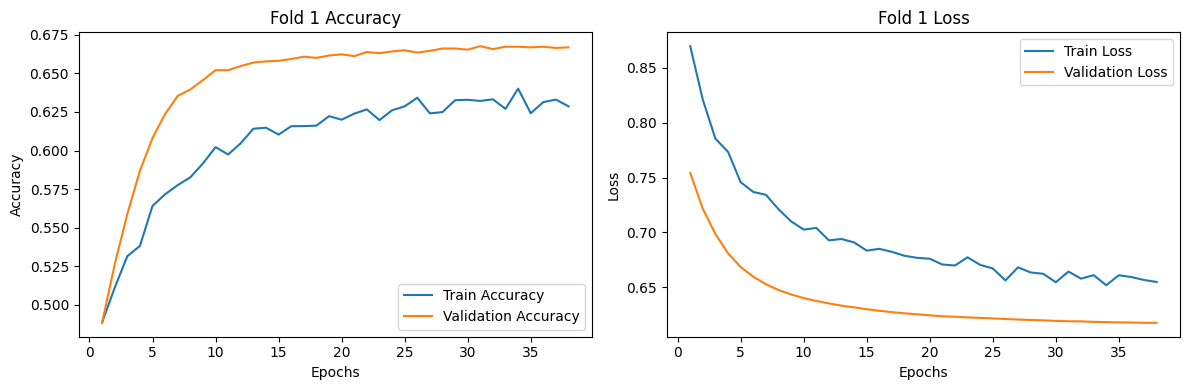

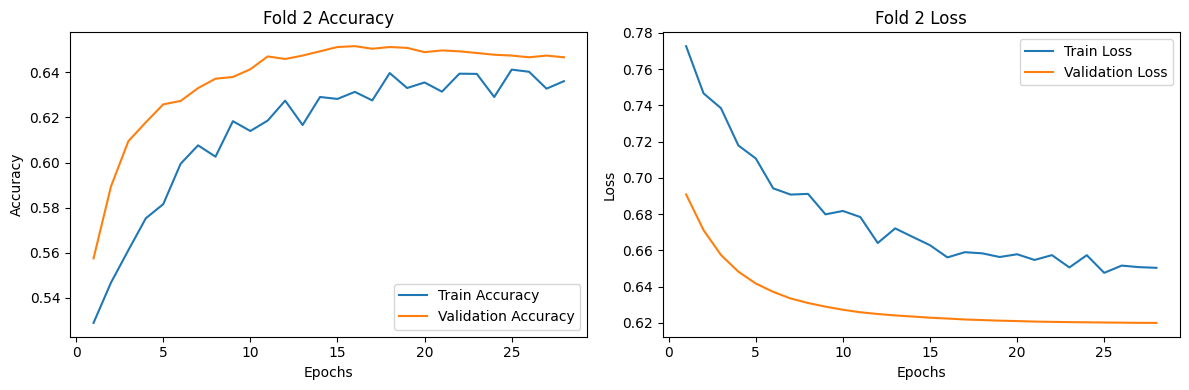

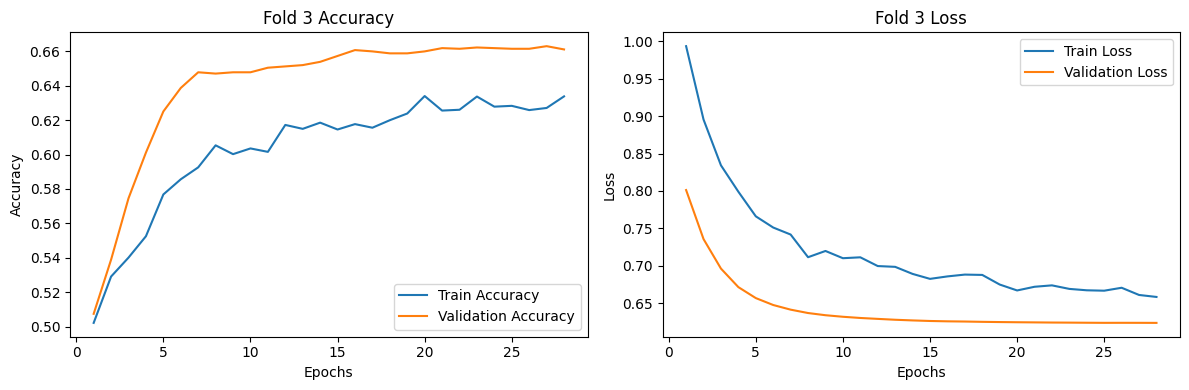

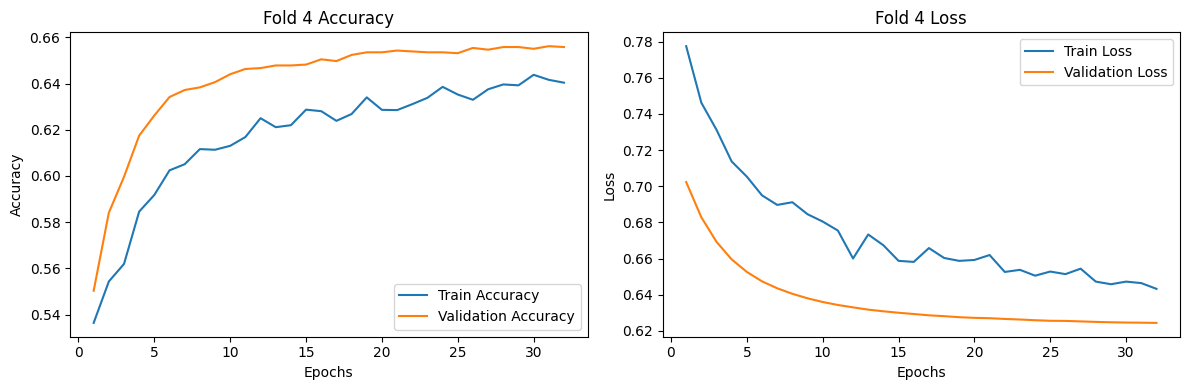

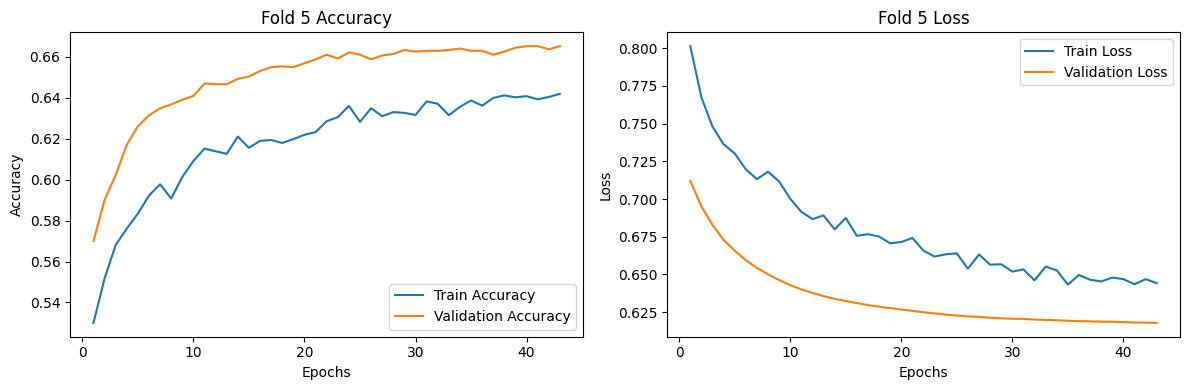

In [9]:
# Fold별 Accuracy와 Loss 저장용 리스트 초기화
all_history = []  # 이 줄을 추가하여 all_history를 명확히 초기화합니다.

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
roc_auc_scores = []

for train_index, valid_index in kf.split(X_resampled):
    print(f"🔄 Fold {fold} 시작")

    # 학습/검증 데이터 분리
    X_train_fold, X_valid_fold = X_resampled[train_index], X_resampled[valid_index]
    y_train_fold, y_valid_fold = y_resampled[train_index], y_resampled[valid_index]

    # 모델 정의
    model = keras.Sequential([
        keras.layers.Dense(128, activation="relu", input_shape=(X_train_fold.shape[1],)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    # 모델 컴파일
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    # 조기 종료 콜백 설정
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.001,
        restore_best_weights=True
    )

    # 모델 학습
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_valid_fold, y_valid_fold),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    # Fold의 학습 결과 저장
    all_history.append(history.history)  # Fold별 학습 결과 저장

    # 검증 데이터 예측 및 평가
    y_valid_pred = model.predict(X_valid_fold).flatten()
    roc_auc = roc_auc_score(y_valid_fold, y_valid_pred)
    print(f"Fold {fold} Validation ROC-AUC: {roc_auc:.4f}")
    roc_auc_scores.append(roc_auc)
    fold += 1

# 교차검증 평균 결과 출력
print(f"✅ 교차검증 평균 ROC-AUC: {np.mean(roc_auc_scores):.4f}")

# 시각화: Fold별 Accuracy와 Loss
for i, history in enumerate(all_history):
    epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy 시각화
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {i + 1} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss 시각화
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {i + 1} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------------------
# 📌 8. 테스트 데이터 예측 (확률 예측)

In [10]:
y_test_pred = model.predict(test_scaled).flatten()  # 확률 값 그대로 사용

# 제출 파일 생성
submission = pd.DataFrame({
    "UID": test_uid["UID"],
    "채무 불이행 확률": y_test_pred  # 확률값을 그대로 저장
})

# CSV 저장
submission.to_csv("submission_17th.csv", index=False)

print("✅ 제출 파일 생성 완료! 'submission_17th.csv' 저장되었습니다.")

65/65 [==============================] - 0s 6ms/step
✅ 제출 파일 생성 완료! 'submission_17th.csv' 저장되었습니다.
